# Model 1: Multivariate-3-RNN

## RNN

### Import các thư viện cần thiết

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

**Cấu hình Seed để đảm bảo tính tái lập trong mô hình LSTM**  

1️⃣ `np.random.seed(1)`  
✅ Đặt **seed** cho NumPy.  
✅ Ảnh hưởng đến tất cả các hàm tạo số ngẫu nhiên của NumPy như:  
   - `np.random.rand()`  
   - `np.random.randn()`  
   - `np.random.randint()`  
   - ...  

2️⃣ `rn.seed(3)`  
✅ Đặt **seed** cho thư viện `random` của Python.  
✅ Ảnh hưởng đến các hàm như:  
   - `random.random()`  
   - `random.randint()`  
   - `random.choice()`  
   - ...  

3️⃣ `tf.random.set_seed(2)`  
✅ Đặt **seed** cho TensorFlow.  
✅ Ảnh hưởng đến:  
   - Việc khởi tạo trọng số ngẫu nhiên của mô hình **TensorFlow/Keras**, ví dụ:  
     - `tf.keras.layers.Dense`  
     - `tf.keras.layers.LSTM`  
   - Các phép toán sử dụng số ngẫu nhiên trong TensorFlow như:  
     - `tf.random.uniform()`  
     - `tf.random.normal()`  
     - ...  

📌 **Ghi chú:**  
- Việc đặt **seed** giúp đảm bảo **tính tái lập** trong các lần chạy mô hình.  
- Điều này giúp so sánh kết quả giữa các lần thử nghiệm một cách chính xác hơn.  


In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from tensorflow.keras import optimizers

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [5]:
plt.style.use('ggplot')

### Hàm callback

In [6]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="3Var-szc-rnn.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"SZC_stock_data.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [8]:
print(df.head)

<bound method NDFrame.head of              open   high    low  close   volume
time                                           
2019-01-15   8.97   8.97   6.58   6.58   109570
2019-01-16   6.58   7.03   6.58   7.03    27940
2019-01-17   7.51   7.51   7.51   7.51   119080
2019-01-18   7.84   7.89   7.51   7.51    50480
2019-01-21   7.51   7.51   7.12   7.12    13560
...           ...    ...    ...    ...      ...
2024-03-14  44.25  45.32  43.33  43.86  2243970
2024-03-15  43.67  43.86  42.94  43.86  2592889
2024-03-18  43.81  43.81  40.79  41.13  3896580
2024-03-19  41.42  41.62  40.79  41.38  1409570
2024-03-20  41.33  42.40  40.99  42.06  1099459

[1293 rows x 5 columns]>


In [9]:
print(df.isnull().sum())

open      0
high      0
low       0
close     0
volume    0
dtype: int64


### Tiền xử lí dữ liệu

In [10]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [11]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.997768
high      0.999022
low       0.998935
close     1.000000
volume    0.444012
Name: close, dtype: float64

**Phân tích tương quan giữa các biến trong dữ liệu chuỗi thời gian**  

🔹 `df.corr()`  
- Tính **ma trận tương quan** giữa tất cả các cột số trong DataFrame.  

🔹 `df.corr()['Close']`  
- Lấy **cột tương quan** giữa tất cả các biến với **giá đóng cửa** (`Close`).  
- Giúp xác định mức độ ảnh hưởng của các biến khác như:  
  - **Giá mở cửa** (`Open`)  
  - **Giá cao nhất** (`High`)  
  - **Giá thấp nhất** (`Low`)  
  - **Khối lượng giao dịch** (`Volume`)  

**Ý nghĩa của tương quan**  

- **Tương quan gần 1** → Biến có mối quan hệ **tỷ lệ thuận** mạnh với giá đóng cửa.  
- **Tương quan gần -1** → Biến có mối quan hệ **tỷ lệ nghịch** mạnh với giá đóng cửa.  
- **Tương quan gần 0** → Biến **ít hoặc không ảnh hưởng** đến giá đóng cửa.  

**Ứng dụng**  

- Chọn các biến có tương quan cao với `Close` để đưa vào mô hình dự đoán.  
- Loại bỏ các biến có tương quan thấp để tránh nhiễu dữ liệu.  


In [ ]:
#  Tính toán các thống kê mô tả như trung bình (mean), độ lệch chuẩn (std), min, max, phần trăm phân vị (25%, 50%, 75%).
print(df.describe().volume) # Giúp kiểm tra phân bố của Volume, phát hiện các giá trị bất thường (outliers).

count    3.185000e+03
mean     3.279171e+06
std      2.776577e+07
min      4.540000e+03
25%      3.809000e+04
50%      6.036000e+04
75%      1.560100e+05
max      3.744900e+08
Name: Volume, dtype: float64


<Axes: >

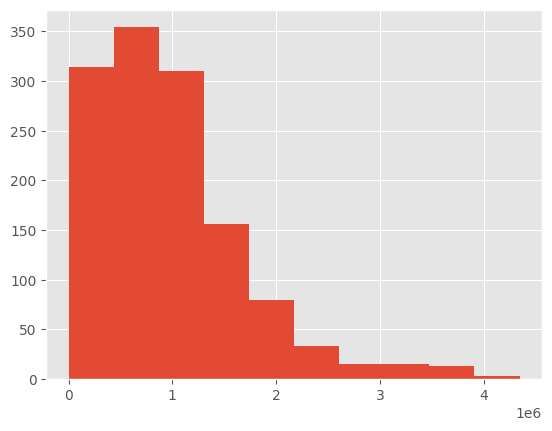

In [12]:
# Vẽ biểu đồ tần suất của Volume
df['volume'].hist(bins=10)

**Phân tích phân bố dữ liệu Volume bằng Histogram**  

🔹 `.hist(bins=10)`  
- Vẽ **biểu đồ histogram** của cột `Volume` với **10 bins (nhóm dữ liệu)**.  
- Giúp trực quan hóa **phân bố dữ liệu**, phát hiện sự **lệch** (skewness) và **giá trị ngoại lai** (outliers).  

**Ý nghĩa của biểu đồ histogram**  

- **Nếu phân bố lệch phải (right-skewed)** → Dữ liệu có nhiều giá trị nhỏ, một số giá trị rất lớn.  
- **Nếu phân bố lệch trái (left-skewed)** → Dữ liệu có nhiều giá trị lớn, một số giá trị rất nhỏ.  
- **Nếu có outliers (điểm nằm xa tập trung chính)** → Có thể cần xử lý như **loại bỏ** hoặc **chuẩn hóa dữ liệu**.  

**Cách xử lý dữ liệu lệch/skewed**  

✅ **Log Transformation** → Dùng `np.log1p(Volume)` để giảm độ lệch.  
✅ **Scaling** → Dùng `MinMaxScaler()` hoặc `StandardScaler()` để chuẩn hóa.  
✅ **Xử lý outliers** → Loại bỏ hoặc thay thế bằng **giá trị trung bình/median**.  


## Train model / Hàm **fit_model_2()**

In [13]:
def fit_model_2(train, val, timesteps, hl, lr, batch, epochs):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    # Loop for training data
    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    # Loop for val data
    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2], input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
    for i in range(len(hl)-1):
        model.add(SimpleRNN(hl[i], activation = 'relu', return_sequences = True))
    model.add(SimpleRNN(hl[-1], activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(learning_rate= lr), loss = 'mean_squared_error')

    # Training the data
    history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
    for layer in model.layers:
        if isinstance(layer, SimpleRNN):
            layer.reset_states() #Đảm bảo mỗi lần huấn luyện không bị ảnh hưởng bởi trạng thái cũ của LSTM.
    return model, history.history['loss'], history.history['val_loss']

###  Bước 1: Đặt Seed để đảm bảo tính tái lập

Giúp đảm bảo mỗi lần chạy chương trình, các giá trị ngẫu nhiên được tạo ra giống nhau, tránh kết quả huấn luyện thay đổi giữa các lần chạy.

In [162]:
"""
np.random.seed(1)
tf.random.set_seed(2)
rn.seed(3)
"""

'\nnp.random.seed(1)\ntf.random.set_seed(2)\nrn.seed(3)\n'

### Bước 2: Chuẩn bị dữ liệu huấn luyện (train) và kiểm định (val)

In [163]:
"""
X_train = []
Y_train = []
X_val = []
Y_val = []

for i in range(timesteps, train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train, Y_train = np.array(X_train, Y_train)

for i in range(timesteps, val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val, Y_val = np.array(X_val, Y_val)  
"""

'\nX_train = []\nY_train = []\nX_val = []\nY_val = []\n\nfor i in range(timesteps, train.shape[0]):\n    X_train.append(train[i-timesteps:i])\n    Y_train.append(train[i][0])\nX_train, Y_train = np.array(X_train, Y_train)\n\nfor i in range(timesteps, val.shape[0]):\n    X_val.append(val[i-timesteps:i])\n    Y_val.append(val[i][0])\nX_val, Y_val = np.array(X_val, Y_val)  \n'

### Bước 3: Xây dựng mô hình RNN

In [164]:
"""
# Xây dựng mô hình RNN
model = Sequential()
model.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
for i in range(len(hl)-1):
    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))
model.add(SimpleRNN(hl[-1], activation='relu'))
model.add(Dense(1))
"""

"\n# Xây dựng mô hình RNN\nmodel = Sequential()\nmodel.add(SimpleRNN(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))\nfor i in range(len(hl)-1):\n    model.add(SimpleRNN(hl[i], activation='relu', return_sequences= True))\nmodel.add(SimpleRNN(hl[-1], activation='relu'))\nmodel.add(Dense(1))\n"

Thêm một lớp **SimpleRNN đầu tiên**:  
-   `X_train.shape[2]`: Số đặc trưng (features).
-   `input_shape = (X_train.shape[1], X_train.shape[2])`: Định dạng đầu vào (timesteps, số đặc trưng).
-   `activation = 'relu'`: Hàm kích hoạt giúp mô hình học phi tuyến tính.
-   `return_sequences = True`: Giữ lại toàn bộ chuỗi đầu ra để sử dụng trong các lớp tiếp theo.

### Bước 4: Biên dịch mô hình

In [165]:
"""
# Biên dịch
model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')
"""

"\n# Biên dịch\nmodel.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')\n"

### Bước 5: Huấn luyện mô hình

In [166]:
"""
history = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)
"""

'\nhistory = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch, validation_data = (X_val, Y_val), verbose = 0, shuffle = False, callbacks=callbacks_list)\n'

**Cấu hình huấn luyện mô hình**

🔹 Tham số trong quá trình huấn luyện  

✅ `epochs = epochs` → Số vòng huấn luyện  
✅ `batch_size = batch` → Kích thước batch  
✅ `validation_data = (X_val, Y_val)` → Dữ liệu kiểm định để theo dõi hiệu suất sau mỗi epoch  
✅ `verbose = 0` → Không hiển thị log huấn luyện (có thể đặt `verbose = 1` để xem tiến trình)  
✅ `shuffle = False` → Không xáo trộn dữ liệu (do chuỗi thời gian có tính thứ tự)  
✅ `callbacks = callbacks_list` → Danh sách callback hỗ trợ huấn luyện  

### Bước 6: Đảm bảo trạng thái không bị ảnh hưởng khi huấn luyện nhiều lần

In [167]:
"""
for layer in model.layers:
    if isinstance(layer, SimpleRNN):
        layer.reset_states()
"""

'\nfor layer in model.layers:\n    if isinstance(layer, SimpleRNN):\n        layer.reset_states()\n'

### Bước 7: Trả về kết quả

In [168]:
"""
return model, history.history['train_loss'], history.history['val_loss']
"""

"\nreturn model, history.history['train_loss'], history.history['val_loss']\n"

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [14]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-3, 1e-4],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [15]:
from itertools import product # Tích đề-các
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
# Khởi tạo danh sách lưu kết quả
    results = []
    best_score = float('inf') # Ban đầu được đặt là vô cùng lớn
    best_params = None # Lưu bộ siêu tham số có hiệu suất tốt nhất
# Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())
# Lặp qua từng tổ hợp tham số
    for combination in all_combinations:
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

    print(f'Training with param: {params}')
# Huấn luyện với fit.model()
    model, train_loss, val_loss = fit_model_2(train, val, timesteps, hl, lr,  batch_size, num_epochs)
# Đánh giá mô hình với evaluate_model()
    mse, rmse, mape, r2, _, _ = evaluate_model_2(model, test, timesteps)
# Lưu kết quả
    results.append({
        'timesteps': timesteps,
        'hl': hl,
        'lr': lr,
        'batch_size': batch_size,
        'num_epochs': num_epochs,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R²': r2
    })
# Cập nhật bộ siêu tham số tốt nhất nếu RMSE cải thiện
    if rmse < best_score:
        best_score = rmse
        best_params = params

# Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df

## Hàm **Evaluate_model_2()**

In [201]:
"""
# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100"
    """

'\n# Định nghĩa hàm mean_absolute_percentage_error() (MAPE)\ndef mean_absolute_percentage_error(y_true, y_pred):\n    y_true, y_pred = np.array(y_true), np.array(y_pred)\n    return np.mean(np.abs((y_true - y_pred) / y_true))*100"\n    '

In [16]:
def evaluate_model_2(model, test, timesteps):
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)

    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Evaluate model
    Y_hat = model.predict(X_test)                         #chứa dự đoán của model dựa trên đầu vào x_test
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)
    return mse, rmse, mape, r2, Y_test, Y_hat

## Plot chart (vẽ biểu đồ)

In [17]:
# Plotting the predictions
def plot_data_2(Y_test,Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivatiate-RNN")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [18]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [19]:
# Extracting the series
series = df[['close', 'high', 'low']] # Picking the multivariate series
print(series.shape)
series

(1293, 3)


,close,high,low
time,,,
2019-01-15,6.58,8.97,6.58
2019-01-16,7.03,7.03,6.58
2019-01-17,7.51,7.51,7.51
2019-01-18,7.51,7.89,7.51
2019-01-21,7.12,7.51,7.12
...,...,...,...
2024-03-14,43.86,45.32,43.33
2024-03-15,43.86,43.86,42.94
2024-03-18,41.13,43.81,40.79


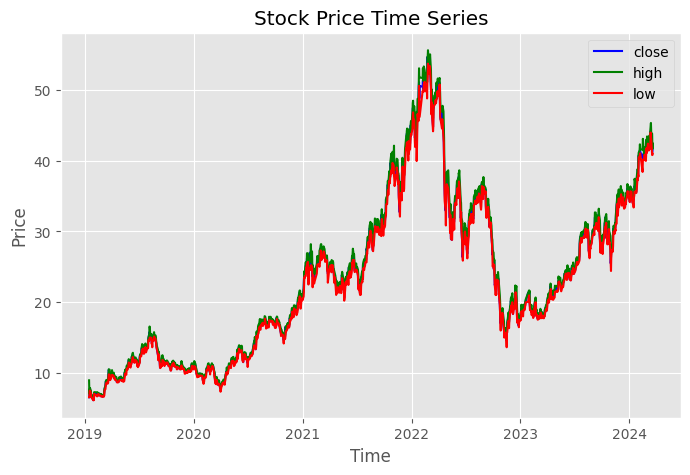

In [21]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(series.index, series['close'], label='close', color='blue')
plt.plot(series.index, series['high'], label='high', color='green')
plt.plot(series.index, series['low'], label='low', color='red')

# Định dạng biểu đồ
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Time Series')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [22]:
series.shape

(1293, 3)

In [23]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(907, 3) (193, 3) (193, 3)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [24]:
# Chuẩn hóa
sc = MinMaxScaler() # Tạo bộ chuẩn hóa MinMaxScaler
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(907, 3) (193, 3) (193, 3)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [25]:
from keras.layers import GRU

In [26]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best Parameters:", best_params)
print("Best RMSE Score:", best_score)
print(results_df)


Training with param: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.10446, saving model to 3Var-szc-rnn.h5



Epoch 2: val_loss improved from 0.10446 to 0.09559, saving model to 3Var-szc-rnn.h5



Epoch 3: val_loss improved from 0.09559 to 0.08587, saving model to 3Var-szc-rnn.h5



Epoch 4: val_loss improved from 0.08587 to 0.07659, saving model to 3Var-szc-rnn.h5



Epoch 5: val_loss improved from 0.07659 to 0.06875, saving model to 3Var-szc-rnn.h5



Epoch 6: val_loss improved from 0.06875 to 0.06256, saving model to 3Var-szc-rnn.h5



Epoch 7: val_loss improved from 0.06256 to 0.05595, saving model to 3Var-szc-rnn.h5



Epoch 8: val_loss improved from 0.05595 to 0.04995, saving model to 3Var-szc-rnn.h5



Epoch 9: val_loss improved from 0.04995 to 0.04469, saving model to 3Var-szc-rnn.h5



Epoch 10: val_loss improved from 0.04469 to 0.03933, saving model to 3Var-szc-rnn.h5



Epoch 11: val_loss improved from 0.03933 to 0.03349, saving model to 3Var-szc-rnn.h5



Epoch 12: val_loss improved from 0.03349 to 0.02757, saving model to 3Var-szc-rnn.h5



Epoch 13: val_loss improved from 0.02757 to 0.02183, saving model to 3Var-szc-rnn.h5



Epoch 14: val_loss improved from 0.02183 to 0.01645, saving model to 3Var-szc-rnn.h5



Epoch 15: val_loss improved from 0.01645 to 0.01194, saving model to 3Var-szc-rnn.h5



Epoch 16: val_loss improved from 0.01194 to 0.00803, saving model to 3Var-szc-rnn.h5



Epoch 17: val_loss improved from 0.00803 to 0.00485, saving model to 3Var-szc-rnn.h5



Epoch 18: val_loss improved from 0.00485 to 0.00259, saving model to 3Var-szc-rnn.h5



Epoch 19: val_loss improved from 0.00259 to 0.00120, saving model to 3Var-szc-rnn.h5



Epoch 20: val_loss improved from 0.00120 to 0.00053, saving model to 3Var-szc-rnn.h5



Epoch 21: val_loss improved from 0.00053 to 0.00036, saving model to 3Var-szc-rnn.h5



Epoch 22: val_loss did not improve from 0.00036

Epoch 23: val_loss did not improve from 0.00036

Epoch 24: val_loss did not improve from 0.00036

Epoch 25: val_loss did not improve from 0.00036

Epoch 26: val_loss did not improve from 0.00036

Epoch 27: val_loss did not improve from 0.00036

Epoch 28: val_loss did not improve from 0.00036

Epoch 29: val_loss improved from 0.00036 to 0.00036, saving model to 3Var-szc-rnn.h5



Epoch 30: val_loss improved from 0.00036 to 0.00036, saving model to 3Var-szc-rnn.h5



Epoch 31: val_loss improved from 0.00036 to 0.00036, saving model to 3Var-szc-rnn.h5



Epoch 32: val_loss improved from 0.00036 to 0.00036, saving model to 3Var-szc-rnn.h5



Epoch 33: val_loss did not improve from 0.00036

Epoch 34: val_loss did not improve from 0.00036

Epoch 35: val_loss improved from 0.00036 to 0.00036, saving model to 3Var-szc-rnn.h5



Epoch 36: val_loss improved from 0.00036 to 0.00036, saving model to 3Var-szc-rnn.h5



Epoch 37: val_loss improved from 0.00036 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 38: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 39: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 40: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 41: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 42: val_loss did not improve from 0.00035

Epoch 43: val_loss did not improve from 0.00035

Epoch 44: val_loss did not improve from 0.00035

Epoch 45: val_loss did not improve from 0.00035

Epoch 46: val_loss did not improve from 0.00035

Epoch 47: val_loss did not improve from 0.00035

Epoch 48: val_loss did not improve from 0.00035

Epoch 49: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 50: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 51: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 52: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 53: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 54: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 55: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 56: val_loss improved from 0.00035 to 0.00035, saving model to 3Var-szc-rnn.h5



Epoch 57: val_loss improved from 0.00035 to 0.00034, saving model to 3Var-szc-rnn.h5



Epoch 58: val_loss improved from 0.00034 to 0.00034, saving model to 3Var-szc-rnn.h5



Epoch 59: val_loss improved from 0.00034 to 0.00034, saving model to 3Var-szc-rnn.h5



Epoch 60: val_loss improved from 0.00034 to 0.00034, saving model to 3Var-szc-rnn.h5



Epoch 61: val_loss improved from 0.00034 to 0.00034, saving model to 3Var-szc-rnn.h5



Epoch 62: val_loss improved from 0.00034 to 0.00034, saving model to 3Var-szc-rnn.h5



Epoch 63: val_loss improved from 0.00034 to 0.00034, saving model to 3Var-szc-rnn.h5



Epoch 64: val_loss improved from 0.00034 to 0.00034, saving model to 3Var-szc-rnn.h5



Epoch 65: val_loss improved from 0.00034 to 0.00034, saving model to 3Var-szc-rnn.h5



Epoch 66: val_loss improved from 0.00034 to 0.00034, saving model to 3Var-szc-rnn.h5



Epoch 67: val_loss improved from 0.00034 to 0.00033, saving model to 3Var-szc-rnn.h5



Epoch 68: val_loss improved from 0.00033 to 0.00033, saving model to 3Var-szc-rnn.h5



Epoch 69: val_loss improved from 0.00033 to 0.00033, saving model to 3Var-szc-rnn.h5



Epoch 70: val_loss improved from 0.00033 to 0.00033, saving model to 3Var-szc-rnn.h5



Epoch 71: val_loss improved from 0.00033 to 0.00033, saving model to 3Var-szc-rnn.h5



Epoch 72: val_loss improved from 0.00033 to 0.00033, saving model to 3Var-szc-rnn.h5



Epoch 73: val_loss improved from 0.00033 to 0.00033, saving model to 3Var-szc-rnn.h5



Epoch 74: val_loss improved from 0.00033 to 0.00033, saving model to 3Var-szc-rnn.h5



Epoch 75: val_loss improved from 0.00033 to 0.00033, saving model to 3Var-szc-rnn.h5



Epoch 76: val_loss improved from 0.00033 to 0.00033, saving model to 3Var-szc-rnn.h5



Epoch 77: val_loss improved from 0.00033 to 0.00032, saving model to 3Var-szc-rnn.h5



Epoch 78: val_loss improved from 0.00032 to 0.00032, saving model to 3Var-szc-rnn.h5



Epoch 79: val_loss improved from 0.00032 to 0.00032, saving model to 3Var-szc-rnn.h5



Epoch 80: val_loss improved from 0.00032 to 0.00032, saving model to 3Var-szc-rnn.h5



Epoch 81: val_loss improved from 0.00032 to 0.00032, saving model to 3Var-szc-rnn.h5



Epoch 82: val_loss improved from 0.00032 to 0.00032, saving model to 3Var-szc-rnn.h5



Epoch 83: val_loss improved from 0.00032 to 0.00032, saving model to 3Var-szc-rnn.h5



Epoch 84: val_loss improved from 0.00032 to 0.00032, saving model to 3Var-szc-rnn.h5



Epoch 85: val_loss improved from 0.00032 to 0.00032, saving model to 3Var-szc-rnn.h5



Epoch 86: val_loss improved from 0.00032 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 87: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 88: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 89: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 90: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 91: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 92: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 93: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 94: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 95: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 96: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 97: val_loss improved from 0.00031 to 0.00031, saving model to 3Var-szc-rnn.h5



Epoch 98: val_loss improved from 0.00031 to 0.00030, saving model to 3Var-szc-rnn.h5



Epoch 99: val_loss improved from 0.00030 to 0.00030, saving model to 3Var-szc-rnn.h5



Epoch 100: val_loss improved from 0.00030 to 0.00030, saving model to 3Var-szc-rnn.h5



Epoch 101: val_loss improved from 0.00030 to 0.00030, saving model to 3Var-szc-rnn.h5


Epoch 101: early stopping
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
Best Parameters: {'timesteps': 50, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 64, 'num_epochs': 250}
Best RMSE Score: 0.02295946355573617
   timesteps        hl      lr  batch_size  num_epochs       MSE      RMSE  \
0         50  [40, 35]  0.0001          64         250  0.000527  0.022959   

       MAPE        R²  
0  0.032485  0.945832  


### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [27]:
timesteps = 50
hl = [40, 35]
lr = 0.0001
batch_size = 64
num_epochs = 250

model, train_error, val_error = fit_model_2(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00030

Epoch 2: val_loss did not improve from 0.00030

Epoch 3: val_loss did not improve from 0.00030

Epoch 4: val_loss did not improve from 0.00030

Epoch 5: val_loss did not improve from 0.00030

Epoch 6: val_loss did not improve from 0.00030

Epoch 7: val_loss did not improve from 0.00030

Epoch 8: val_loss did not improve from 0.00030

Epoch 9: val_loss did not improve from 0.00030

Epoch 10: val_loss did not improve from 0.00030

Epoch 11: val_loss did not improve from 0.00030

Epoch 12: val_loss did not improve from 0.00030

Epoch 13: val_loss did not improve from 0.00030

Epoch 14: val_loss did not improve from 0.00030

Epoch 15: val_loss did not improve from 0.00030

Epoch 16: val_loss did not improve from 0.00030

Epoch 17: val_loss did not improve from 0.00030

Epoch 18: val_loss did not improve from 0.00030

Epoch 19: val_loss did not improve from 0.00030

Epoch 20: val_loss did not improve from 0.00030

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

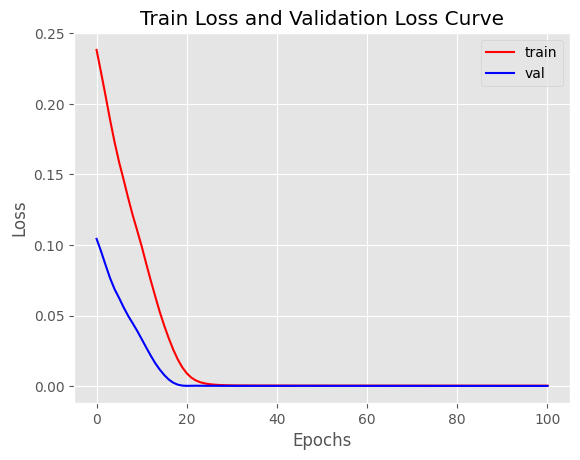

In [28]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [29]:
mse, rmse, mape, r2, true, predicted = evaluate_model_2(model, test, timesteps) #được tính dựa trên bộ dữ liệu đã chuẩn hoá


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 344ms/step


In [30]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0005271369667671774
RMSE = 0.02295946355573617
MAPE = 0.0324854363069905
R-Squared Score = 0.945832428324431


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

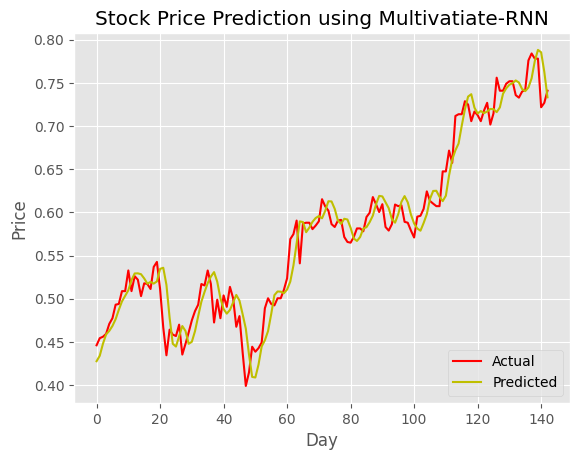

In [31]:
plot_data_2(true, predicted)

In [217]:
# Save a model
model.save('3VAR-VNindex.keras')

In [218]:
del model

# Model 2: Multivariate-3-GRU

## GRU

### Import các thư viện cần thiết

In [32]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

In [33]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras import optimizers

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

from tensorflow.keras.optimizers import Adam

In [36]:
plt.style.use('ggplot')

### Hàm callback

In [37]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="3Var-SZC-gru.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"SZC_stock_data.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [39]:
df.head()

,open,high,low,close,volume
time,,,,,
2019-01-15,8.97,8.97,6.58,6.58,109570
2019-01-16,6.58,7.03,6.58,7.03,27940
2019-01-17,7.51,7.51,7.51,7.51,119080
2019-01-18,7.84,7.89,7.51,7.51,50480
2019-01-21,7.51,7.51,7.12,7.12,13560


In [40]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Tiền xử lí dữ liệu

In [41]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [42]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.997768
high      0.999022
low       0.998935
close     1.000000
volume    0.444012
Name: close, dtype: float64

In [43]:
print(df.describe().volume) 

count    1.293000e+03
mean     9.618657e+05
std      7.256608e+05
min      2.400000e+02
25%      4.538290e+05
50%      8.436720e+05
75%      1.285800e+06
max      4.346420e+06
Name: volume, dtype: float64


<Axes: >

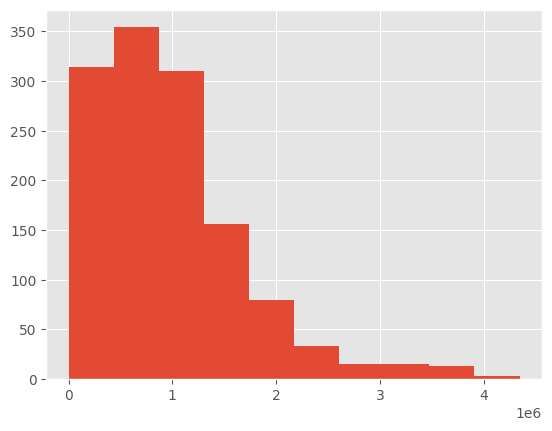

In [44]:
df['volume'].hist(bins= 10)

## Train model / Hàm **fit_model_3()**

In [45]:
def fit_model_3(train, val, timesteps, hl, lr, batch, epochs):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    rn.seed(3)
    """
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Thêm các lớp vào mô hình
    model = Sequential()
    model.add(GRU(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation= 'relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(GRU(hl[i], activation='relu', return_sequences= True))
    model.add(GRU(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện dữ liệu
    history = model.fit(X_train, Y_train, epochs= epochs, batch_size= batch, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)
    
    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, GRU):
            layer.reset_states()
    
    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_3()**

In [46]:
def evaluate_model_3(model, test, timesteps):
    """
    np.random.seed(1)
    tf.random.set_seed(2)
    """
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test= np.array(X_test), np.array(Y_test)

    # Các chỉ số đánh giá
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat


## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [47]:
param_grid = {
    'timesteps': [30, 40, 50],
    'hl': [[40, 35]],
    'lr': [1e-4, 1e-3],
    'batch_size': [32, 64],
    'num_epochs': [200, 250]
}

In [48]:
# Hàm grid search
def grid_search_rnn(train, val, test, param_grid):
    results = []
    best_score = float('inf')
    best_params = None

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*(param_grid.values())))
    param_names = param_grid.keys()

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f'Training with params: {params}')

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_3(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

        # Trả về kết quả
        results_df = pd.DataFrame(results)
        return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [49]:
# Plotting the predictions
def plot_data_3(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Stock Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'], loc = 'lower right')
    plt.show()

In [50]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [51]:
# Extracting the series
series = df[['close', 'high', 'low']] # Picking the multivariate series
print(series.shape)
series

(1293, 3)


,close,high,low
time,,,
2019-01-15,6.58,8.97,6.58
2019-01-16,7.03,7.03,6.58
2019-01-17,7.51,7.51,7.51
2019-01-18,7.51,7.89,7.51
2019-01-21,7.12,7.51,7.12
...,...,...,...
2024-03-14,43.86,45.32,43.33
2024-03-15,43.86,43.86,42.94
2024-03-18,41.13,43.81,40.79


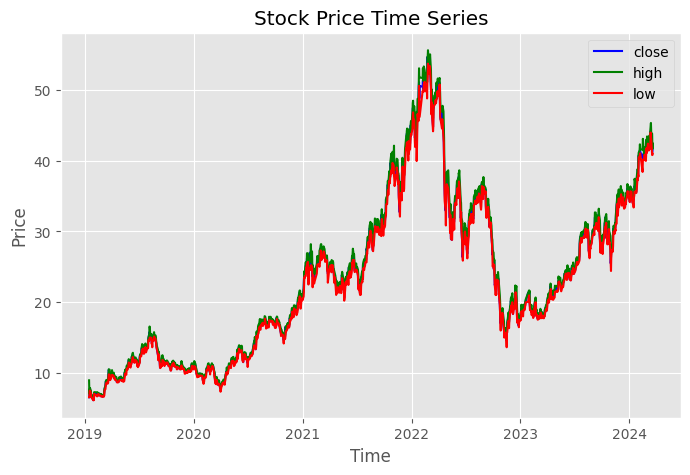

In [53]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(series.index, series['close'], label='close', color='blue')
plt.plot(series.index, series['high'], label='high', color='green')
plt.plot(series.index, series['low'], label='low', color='red')

# Định dạng biểu đồ
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Time Series')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [54]:
series.shape

(1293, 3)

In [55]:
n = series.shape[0]
val_size =  test_size = int(n * 0.15)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)

(907, 3) (193, 3) (193, 3)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [56]:
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(907, 3) (193, 3) (193, 3)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [57]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}


c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss improved from inf to 0.08851, saving model to 3Var-SZC-gru.h5



Epoch 2: val_loss improved from 0.08851 to 0.07613, saving model to 3Var-SZC-gru.h5



Epoch 3: val_loss improved from 0.07613 to 0.06757, saving model to 3Var-SZC-gru.h5



Epoch 4: val_loss improved from 0.06757 to 0.05917, saving model to 3Var-SZC-gru.h5



Epoch 5: val_loss improved from 0.05917 to 0.05076, saving model to 3Var-SZC-gru.h5



Epoch 6: val_loss improved from 0.05076 to 0.04075, saving model to 3Var-SZC-gru.h5



Epoch 7: val_loss improved from 0.04075 to 0.03048, saving model to 3Var-SZC-gru.h5



Epoch 8: val_loss improved from 0.03048 to 0.02123, saving model to 3Var-SZC-gru.h5



Epoch 9: val_loss improved from 0.02123 to 0.01340, saving model to 3Var-SZC-gru.h5



Epoch 10: val_loss improved from 0.01340 to 0.00784, saving model to 3Var-SZC-gru.h5



Epoch 11: val_loss improved from 0.00784 to 0.00411, saving model to 3Var-SZC-gru.h5



Epoch 12: val_loss improved from 0.00411 to 0.00199, saving model to 3Var-SZC-gru.h5



Epoch 13: val_loss improved from 0.00199 to 0.00108, saving model to 3Var-SZC-gru.h5



Epoch 14: val_loss improved from 0.00108 to 0.00080, saving model to 3Var-SZC-gru.h5



Epoch 15: val_loss did not improve from 0.00080

Epoch 16: val_loss did not improve from 0.00080

Epoch 17: val_loss did not improve from 0.00080

Epoch 18: val_loss did not improve from 0.00080

Epoch 19: val_loss did not improve from 0.00080

Epoch 20: val_loss improved from 0.00080 to 0.00078, saving model to 3Var-SZC-gru.h5



Epoch 21: val_loss improved from 0.00078 to 0.00066, saving model to 3Var-SZC-gru.h5



Epoch 22: val_loss improved from 0.00066 to 0.00057, saving model to 3Var-SZC-gru.h5



Epoch 23: val_loss improved from 0.00057 to 0.00048, saving model to 3Var-SZC-gru.h5



Epoch 24: val_loss improved from 0.00048 to 0.00046, saving model to 3Var-SZC-gru.h5



Epoch 25: val_loss improved from 0.00046 to 0.00045, saving model to 3Var-SZC-gru.h5



Epoch 26: val_loss did not improve from 0.00045

Epoch 27: val_loss did not improve from 0.00045

Epoch 28: val_loss did not improve from 0.00045

Epoch 29: val_loss did not improve from 0.00045

Epoch 30: val_loss did not improve from 0.00045

Epoch 31: val_loss did not improve from 0.00045

Epoch 32: val_loss improved from 0.00045 to 0.00045, saving model to 3Var-SZC-gru.h5



Epoch 33: val_loss improved from 0.00045 to 0.00045, saving model to 3Var-SZC-gru.h5



Epoch 34: val_loss improved from 0.00045 to 0.00045, saving model to 3Var-SZC-gru.h5



Epoch 35: val_loss improved from 0.00045 to 0.00045, saving model to 3Var-SZC-gru.h5



Epoch 36: val_loss improved from 0.00045 to 0.00045, saving model to 3Var-SZC-gru.h5



Epoch 37: val_loss improved from 0.00045 to 0.00044, saving model to 3Var-SZC-gru.h5



Epoch 38: val_loss improved from 0.00044 to 0.00044, saving model to 3Var-SZC-gru.h5



Epoch 39: val_loss improved from 0.00044 to 0.00044, saving model to 3Var-SZC-gru.h5



Epoch 40: val_loss improved from 0.00044 to 0.00044, saving model to 3Var-SZC-gru.h5



Epoch 41: val_loss improved from 0.00044 to 0.00044, saving model to 3Var-SZC-gru.h5



Epoch 42: val_loss improved from 0.00044 to 0.00044, saving model to 3Var-SZC-gru.h5



Epoch 43: val_loss improved from 0.00044 to 0.00044, saving model to 3Var-SZC-gru.h5



Epoch 44: val_loss improved from 0.00044 to 0.00044, saving model to 3Var-SZC-gru.h5



Epoch 45: val_loss improved from 0.00044 to 0.00044, saving model to 3Var-SZC-gru.h5



Epoch 46: val_loss improved from 0.00044 to 0.00044, saving model to 3Var-SZC-gru.h5



Epoch 47: val_loss improved from 0.00044 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 48: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 49: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 50: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 51: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 52: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 53: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 54: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 55: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 56: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 57: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 58: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 59: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 60: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 61: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 62: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 63: val_loss improved from 0.00043 to 0.00043, saving model to 3Var-SZC-gru.h5



Epoch 64: val_loss improved from 0.00043 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 65: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 66: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 67: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 68: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 69: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 70: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 71: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 72: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 73: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 74: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 75: val_loss improved from 0.00042 to 0.00042, saving model to 3Var-SZC-gru.h5



Epoch 76: val_loss improved from 0.00042 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 77: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 78: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 79: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 80: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 81: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 82: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 83: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 84: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 85: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 86: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 87: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 88: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 89: val_loss improved from 0.00041 to 0.00041, saving model to 3Var-SZC-gru.h5



Epoch 90: val_loss improved from 0.00041 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 91: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 92: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 93: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 94: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 95: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 96: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 97: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 98: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 99: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 100: val_loss did not improve from 0.00040

Epoch 101: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 102: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5



Epoch 103: val_loss improved from 0.00040 to 0.00040, saving model to 3Var-SZC-gru.h5


Epoch 103: early stopping


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024CAF7D1940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 512ms/step
Best parameters: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}
Best RMSE score: 0.025373346972391197


### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [58]:
timesteps = 30
hl = [40, 35]
lr = 1e-4
batch_size = 32
num_epochs = 200

model, train_loss, val_loss = fit_model_3(train, val, timesteps, hl, lr, batch_size, num_epochs)

c:\Users\84368\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00040

Epoch 2: val_loss did not improve from 0.00040

Epoch 3: val_loss did not improve from 0.00040

Epoch 4: val_loss did not improve from 0.00040

Epoch 5: val_loss did not improve from 0.00040

Epoch 6: val_loss did not improve from 0.00040

Epoch 7: val_loss did not improve from 0.00040

Epoch 8: val_loss did not improve from 0.00040

Epoch 9: val_loss did not improve from 0.00040

Epoch 10: val_loss did not improve from 0.00040

Epoch 11: val_loss did not improve from 0.00040

Epoch 12: val_loss did not improve from 0.00040

Epoch 13: val_loss did not improve from 0.00040

Epoch 14: val_loss did not improve from 0.00040

Epoch 15: val_loss did not improve from 0.00040

Epoch 16: val_loss did not improve from 0.00040

Epoch 17: val_loss did not improve from 0.00040

Epoch 18: val_loss did not improve from 0.00040

Epoch 19: val_loss did not improve from 0.00040

Epoch 20: val_loss did not improve from 0.00040

Epoch 21: val_loss did not i

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

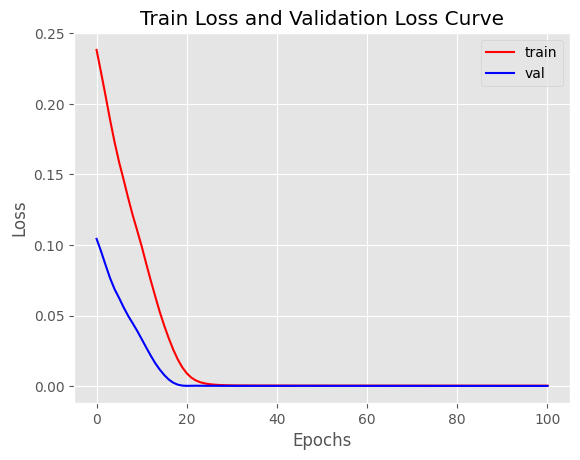

In [59]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [60]:
mse, rmse, mape, r2, true, predicted = evaluate_model_3(model, test, timesteps)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step


In [61]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.000675471966148317
RMSE = 0.025989843519119482
MAPE = 0.03636948693366373
R-Squared Score = 0.9295601006711414


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

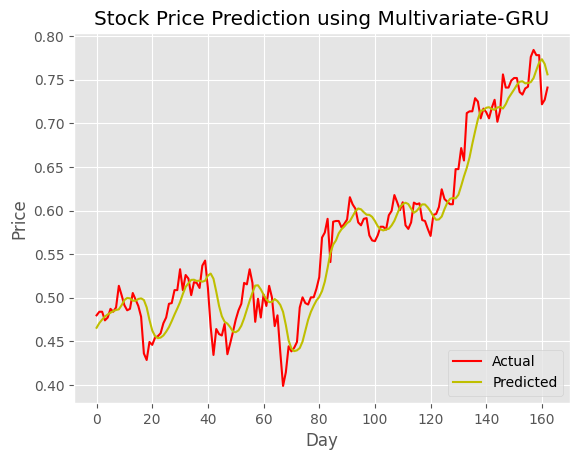

In [62]:
plot_data_3(true, predicted)

In [205]:
# Save a model
model.save('3VAR-VNindex-model2.keras')

In [206]:
del model

# Model 3: Multivariate-3-LSTM

## LSTM

### Import các thư viện cần thiết

In [4]:
import os
os.environ['PYTHONHASHSEED'] = '0' # đảm bảo rằng các giá trị băm của đối tượng bất biến (dict, set, chuỗi, tuple...) luôn giống nhau giữa các lần chạy

import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow as tf
tf.random.set_seed(2)

2025-06-02 17:26:30.792403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748885191.009125      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748885191.072778      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras import optimizers

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt
import datetime as dt
import time

In [8]:
plt.style.use('ggplot')

### Hàm callback

In [9]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')  
checkpoint = ModelCheckpoint(
    filepath="3Var_szc_lstm.h5",   # Tên file lưu mô hình
    monitor="val_loss",         # Theo dõi val_loss
    save_best_only=True,        # Chỉ lưu khi tốt hơn mô hình trước đó
    mode="min",                 # Giảm min của val_loss là tốt nhất
    verbose=1
)
callbacks_list = [earlystop, checkpoint] 

### Đọc dữ liệu từ file csv

In [ ]:
url = r"SZC_stock_data.csv"
df = pd.read_csv(url, parse_dates= True, index_col= 0)

In [11]:
df.head()

,open,high,low,close,volume
time,,,,,
2019-01-15,8.97,8.97,6.58,6.58,109570
2019-01-16,6.58,7.03,6.58,7.03,27940
2019-01-17,7.51,7.51,7.51,7.51,119080
2019-01-18,7.84,7.89,7.51,7.51,50480
2019-01-21,7.51,7.51,7.12,7.12,13560


In [12]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

### Tiền xử lí dữ liệu

In [13]:
# Xóa các dòng có giá trị Volume bằng 0
df.drop(df[df['volume']==0].index, inplace=True)

In [14]:
# Ma trận tương quan (ở đây là Pearson tương quan tuyến tính)
df.corr()['close']

open      0.997768
high      0.999022
low       0.998935
close     1.000000
volume    0.444012
Name: close, dtype: float64

count    1.293000e+03
mean     9.618657e+05
std      7.256608e+05
min      2.400000e+02
25%      4.538290e+05
50%      8.436720e+05
75%      1.285800e+06
max      4.346420e+06
Name: volume, dtype: float64


<Axes: >

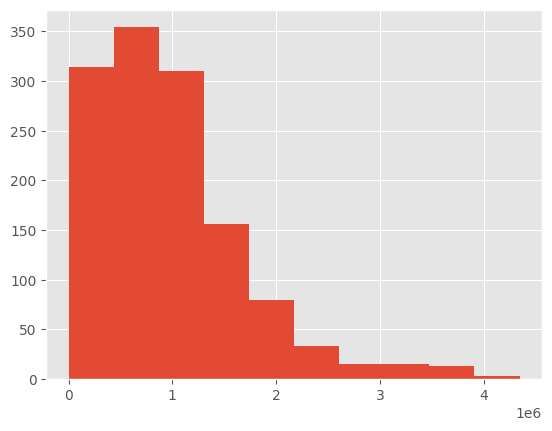

In [15]:
print(df.describe().volume) 
df['volume'].hist(bins= 10)

## Train model / Hàm **fit_model_4()**

In [16]:
def fit_model_4(train, val, timesteps, hl, lr, batch, epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []

    for i in range(timesteps, train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)

    for i in range(timesteps, val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val, Y_val = np.array(X_val), np.array(Y_val)

    # Xây dựng mô hình
    model = Sequential()
    model.add(LSTM(X_train.shape[2], input_shape= (X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences= True))
    for i in range(len(hl)-1):
        model.add(LSTM(hl[i], activation='relu', return_sequences= True))
    model.add(LSTM(hl[-1], activation='relu'))
    model.add(Dense(1))

    # Biên dịch
    model.compile(optimizer= optimizers.Adam(learning_rate= lr), loss= 'mean_squared_error')

    # Huấn luyện mô hình
    history = model.fit(X_train, Y_train, batch_size= batch, epochs= epochs, validation_data= (X_val, Y_val), verbose= 0, shuffle= False, callbacks= callbacks_list)

    # Đặt lại trạng thái
    for layer in model.layers:
        if isinstance(layer, LSTM):
            layer.reset_state()

    return model, history.history['loss'], history.history['val_loss']

## Hàm **Evaluate_model_4()**

In [17]:
def evaluate_model_4(model, test, timesteps):
    X_test = []
    Y_test = []

    for i in range(timesteps, test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)

    # Các chỉ số
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_hat)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(Y_test, Y_hat)
    r2 = r2_score(Y_test, Y_hat)

    return mse, rmse, mape, r2, Y_test, Y_hat

## **Grid Search**: Tìm kiếm siêu tham số tối ưu 

In [18]:
param_grid = {
    'timesteps': [30, 40, 50],  # Số giá trị trước đó để dự đoán
    'hl': [ [40, 35]], # Cấu trúc lớp ẩn
    'lr': [1e-3, 1e-4],  # Tốc độ học
    'batch_size': [32, 64],  # Kích thước batch
    'num_epochs': [200, 250],  # Số epoch
}

In [19]:
from itertools import product
import pandas as pd

# Hàm Grid Search
def grid_search_rnn(train, val, test, param_grid):
    results = []  # Lưu kết quả của từng tổ hợp tham số
    best_score = float('inf')  # Lưu RMSE tốt nhất
    best_params = None  # Lưu bộ tham số tốt nhất

    # Tạo tất cả các tổ hợp tham số
    all_combinations = list(product(*param_grid.values()))
    param_names = list(param_grid.keys())

    for combination in all_combinations:
        # Gán giá trị tham số hiện tại
        params = dict(zip(param_names, combination))
        timesteps = params['timesteps']
        hl = params['hl']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']

        print(f"Training with params: {params}")

        # Huấn luyện mô hình
        model, train_loss, val_loss = fit_model_4(
            train, val, timesteps, hl, lr, batch_size, num_epochs
        )

        # Đánh giá mô hình
        mse, rmse, mape, r2, _, _ = evaluate_model_4(model, test, timesteps)

        # Lưu kết quả
        results.append({
            'timesteps': timesteps,
            'hl': hl,
            'lr': lr,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'R²': r2
        })

        # Cập nhật tham số tốt nhất nếu RMSE cải thiện
        if rmse < best_score:
            best_score = rmse
            best_params = params

    # Trả về kết quả
    results_df = pd.DataFrame(results)
    return best_params, best_score, results_df


## Plot chart (vẽ biểu đồ)

In [20]:
# Plotting the predictions
def plot_data_4(Y_test, Y_hat):
    plt.plot(Y_test, c = 'r')
    plt.plot(Y_hat, c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual', 'Predicted'], loc = 'lower right')
    plt.show()

In [21]:
# Plotting the training errors: trực quan loss qua các epoch -> thấy qtr học mô hình, xem có overfitting ko
def plot_error(train_loss, val_loss):
    plt.plot(train_loss, c = 'r')
    plt.plot(val_loss, c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Train Loss and Validation Loss Curve')
    plt.legend(['train', 'val'], loc = 'upper right')
    plt.show()

## **Model building**: Xây dựng mô hình

### Bước 1: Trích xuất và trực quan hóa dữ liệu

In [22]:
# Extracting the series
series = df[['close', 'high', 'low']] # Picking the multivariate series
print(series.shape)
series

(1293, 3)


,close,high,low
time,,,
2019-01-15,6.58,8.97,6.58
2019-01-16,7.03,7.03,6.58
2019-01-17,7.51,7.51,7.51
2019-01-18,7.51,7.89,7.51
2019-01-21,7.12,7.51,7.12
...,...,...,...
2024-03-14,43.86,45.32,43.33
2024-03-15,43.86,43.86,42.94
2024-03-18,41.13,43.81,40.79


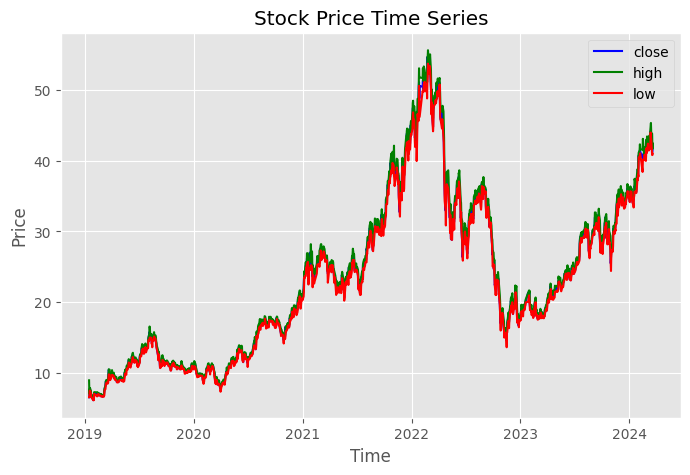

In [23]:
# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(series.index, series['close'], label='close', color='blue')
plt.plot(series.index, series['high'], label='high', color='green')
plt.plot(series.index, series['low'], label='low', color='red')

# Định dạng biểu đồ
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Stock Price Time Series')
plt.legend()
plt.grid(True)

# Hiển thị biểu đồ
plt.show()

### Bước 2: Chia dữ liệu thành các tập Train, Validation, Test

In [24]:
series.shape

(1293, 3)

In [25]:

n = series.shape[0]
val_size =  test_size = int(n * 0.2)
train_size = n - val_size - test_size # Để tránh sai số làm mất dữ liệu

# Chia tập dữ liệu theo thứ tự thời gian
train_data = series.iloc[:train_size].values
val_data = series.iloc[train_size:train_size + val_size].values
test_data = series.iloc[(train_size + val_size):].values
# Kiểm tra kích thước của từng tập
print(train_data.shape, val_data.shape, test_data.shape)


(777, 3) (258, 3) (258, 3)


### Bước 3: Chuẩn hóa dữ liệu bằng MinMaxScaler

In [26]:
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)

print(train.shape, val.shape, test.shape)

(777, 3) (258, 3) (258, 3)


### Bước 4: Tìm siêu tham số tốt nhất bằng Grid Search

In [26]:
best_params, best_score, results_df = grid_search_rnn(train, val, test, param_grid)

print("Best parameters:", best_params)
print("Best RMSE score:", best_score)

Training with params: {'timesteps': 30, 'hl': [40, 35], 'lr': 0.001, 'batch_size': 32, 'num_epochs': 200}


I0000 00:00:1748830407.118197      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748830407.118924      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1748830414.295903     107 service.cc:148] XLA service 0x78a358006bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748830414.296519     107 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Ca


Epoch 1: val_loss improved from inf to 0.02096, saving model to 3Var_szc_lstm.h5

Epoch 2: val_loss improved from 0.02096 to 0.01434, saving model to 3Var_szc_lstm.h5

Epoch 3: val_loss improved from 0.01434 to 0.01272, saving model to 3Var_szc_lstm.h5

Epoch 4: val_loss improved from 0.01272 to 0.00651, saving model to 3Var_szc_lstm.h5

Epoch 5: val_loss did not improve from 0.00651

Epoch 6: val_loss did not improve from 0.00651

Epoch 7: val_loss did not improve from 0.00651

Epoch 8: val_loss did not improve from 0.00651

Epoch 9: val_loss did not improve from 0.00651

Epoch 10: val_loss did not improve from 0.00651

Epoch 11: val_loss did not improve from 0.00651

Epoch 12: val_loss improved from 0.00651 to 0.00546, saving model to 3Var_szc_lstm.h5

Epoch 13: val_loss did not improve from 0.00546

Epoch 14: val_loss improved from 0.00546 to 0.00517, saving model to 3Var_szc_lstm.h5

Epoch 15: val_loss did not improve from 0.00517

Epoch 16: val_loss improved from 0.00517 to 0.005

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1: val_loss did not improve from 0.00206

Epoch 2: val_loss did not improve from 0.00206

Epoch 3: val_loss did not improve from 0.00206

Epoch 4: val_loss did not improve from 0.00206

Epoch 5: val_loss did not improve from 0.00206

Epoch 6: val_loss did not improve from 0.00206

Epoch 7: val_loss did not improve from 0.00206

Epoch 8: val_loss did not improve from 0.00206

Epoch 9: val_loss did not improve from 0.00206

Epoch 10: val_loss did not improve from 0.00206

Epoch 11: val_loss did not improve from 0.00206

Epoch 12: val_loss did not improve from 0.00206

Epoch 13: val_loss did not improve from 0.00206

Epoch 14: val_loss did not improve from 0.00206

Epoch 15: val_loss did not improve from 0.00206

Epoch 16: val_loss did not improve from 0.00206

Epoch 17: val_loss did not improve from 0.00206

Epoch 18: val_loss did not improve from 0.00206

Epoch 19: val_loss did not improve from 0.00206

Epoch 20: val_loss did not improve from 0.00206

Epoch 21: val_loss did not i

### Bước 5: Huấn luyện mô hình với bộ tham số tối ưu

In [27]:
timesteps = 30
hl = [40, 35]
lr = 1e-3
batch_size = 32
num_epochs = 200

model, train_error, val_error = fit_model_4(train, val, timesteps, hl, lr, batch_size, num_epochs)

I0000 00:00:1748885259.490265      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748885259.491052      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1748885266.205198     102 service.cc:148] XLA service 0x4252cf40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748885266.206349     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capabi


Epoch 1: val_loss improved from inf to 0.02096, saving model to 3Var_szc_lstm.h5

Epoch 2: val_loss improved from 0.02096 to 0.01434, saving model to 3Var_szc_lstm.h5

Epoch 3: val_loss improved from 0.01434 to 0.01272, saving model to 3Var_szc_lstm.h5

Epoch 4: val_loss improved from 0.01272 to 0.00651, saving model to 3Var_szc_lstm.h5

Epoch 5: val_loss did not improve from 0.00651

Epoch 6: val_loss did not improve from 0.00651

Epoch 7: val_loss did not improve from 0.00651

Epoch 8: val_loss did not improve from 0.00651

Epoch 9: val_loss did not improve from 0.00651

Epoch 10: val_loss did not improve from 0.00651

Epoch 11: val_loss did not improve from 0.00651

Epoch 12: val_loss improved from 0.00651 to 0.00546, saving model to 3Var_szc_lstm.h5

Epoch 13: val_loss did not improve from 0.00546

Epoch 14: val_loss improved from 0.00546 to 0.00517, saving model to 3Var_szc_lstm.h5

Epoch 15: val_loss did not improve from 0.00517

Epoch 16: val_loss improved from 0.00517 to 0.005

### Bước 6: Đánh giá mô hình và trực quan hóa kết quả

#### 6.1. Vẽ biểu đồ train_loss và val_loss

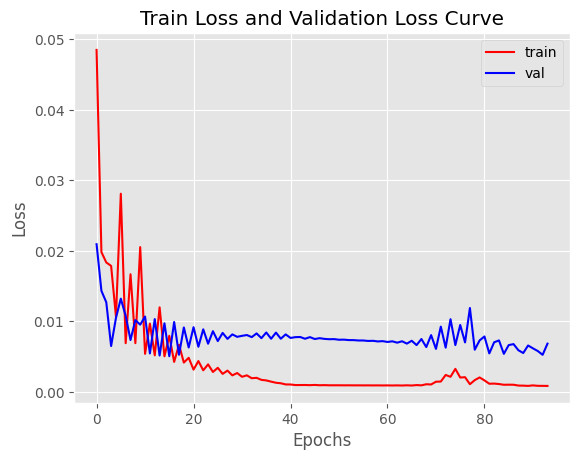

In [28]:
plot_error(train_error, val_error)

#### 6.2. Đánh giá mô hình trên tập test

In [29]:
mse, rmse, mape, r2, true, predicted = evaluate_model_4(model, test, timesteps)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step


In [30]:
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('MAPE = {}'.format(mape))
print('R-Squared Score = {}'.format(r2))

MSE = 0.0012721332810260054
RMSE = 0.03566697745851203
MAPE = 0.05607440256719011
R-Squared Score = 0.9163820878243756


#### 6.3. Vẽ đồ thị dự đoán vs thực tế

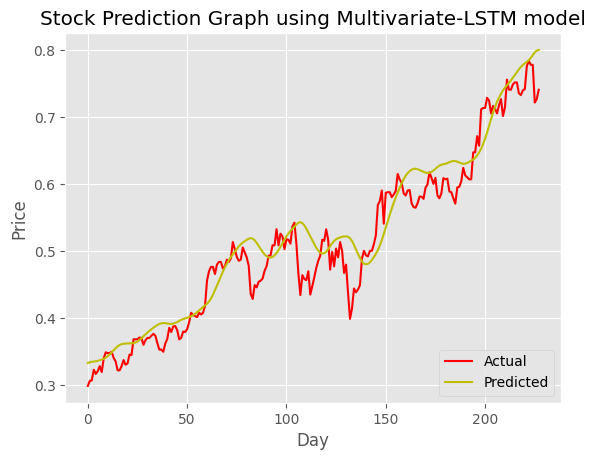

In [31]:
plot_data_4(true, predicted)

In [30]:
# Save a model
model.save('3VAR-szc-lstm.keras')

In [ ]:
del model